In [270]:
import h5py
import pandas as pd
import numpy as np
import pickle
import torch

%matplotlib inline

import Levenshtein as L
import umap
import pandas as pd
import numpy as np
import networkx as nx

from matplotlib import pyplot as plt

from collections import Counter

import os

# DKM scores, our 4 antigens

TRB only - 70.762 66.533
TRA+TRB  - 75 76

# Load Atchkley factors from DKM files

In [42]:
with open("../features/kidera.pkl", "rb") as kfile:
    tmp = pickle.load(kfile)
tmp["A"].shape

torch.Size([10])

In [47]:
af = pd.read_csv("../atchley_factors_normalized.csv", header=None)
af.columns = ["AA", "P1", "P2", "P3", "P4", "P5"]
af

,AA,P1,P2,P3,P4,P5
0,A,-0.603847,-1.330233,-0.344529,1.630294,-0.093537
1,C,-1.372194,0.475222,-0.405171,-1.059000,-0.163393
2,D,1.072825,0.308674,-1.718604,-0.268826,-2.077715
3,E,1.386498,-1.484518,0.694371,0.117436,-0.536388
4,F,-1.027868,-0.602738,0.888988,-0.412116,0.264076
5,G,-0.392347,1.688054,0.625267,1.085167,1.322818
6,H,0.343304,-0.425973,-0.786414,-1.530406,-0.049957
7,I,-1.265933,-0.558802,1.001810,0.408170,0.522994
8,K,1.870802,-0.573106,0.250605,-0.287516,1.056210
9,L,-1.041151,-1.008377,-0.707439,1.314639,-0.584455


In [48]:
af_dict = {}
for af_row in af.itertuples():
    af_dict[af_row[1]] = torch.tensor(af_row[2:7])
af_dict

{'A': tensor([-0.6038, -1.3302, -0.3445,  1.6303, -0.0935]),
 'C': tensor([-1.3722,  0.4752, -0.4052, -1.0590, -0.1634]),
 'D': tensor([ 1.0728,  0.3087, -1.7186, -0.2688, -2.0777]),
 'E': tensor([ 1.3865, -1.4845,  0.6944,  0.1174, -0.5364]),
 'F': tensor([-1.0279, -0.6027,  0.8890, -0.4121,  0.2641]),
 'G': tensor([-0.3923,  1.6881,  0.6253,  1.0852,  1.3228]),
 'H': tensor([ 0.3433, -0.4260, -0.7864, -1.5304, -0.0500]),
 'I': tensor([-1.2659, -0.5588,  1.0018,  0.4082,  0.5230]),
 'K': tensor([ 1.8708, -0.5731,  0.2506, -0.2875,  1.0562]),
 'L': tensor([-1.0412, -1.0084, -0.7074,  1.3146, -0.5845]),
 'M': tensor([-0.6774, -1.5571,  1.0432, -1.0434,  0.7768]),
 'N': tensor([ 0.9655,  0.8461,  0.6107, -0.1754,  0.5980]),
 'P': tensor([ 0.1931,  2.1264, -0.7653,  0.4372, -0.8921]),
 'Q': tensor([ 0.9512, -0.1828, -1.4126, -0.5222, -1.1875]),
 'R': tensor([ 1.5714, -0.0561,  0.7061,  0.4570,  1.8567]),
 'S': tensor([-0.2330,  1.4295, -2.2376,  0.6958, -1.6964]),
 'T': tensor([-0.0327,  

In [49]:
with open("../features/atchley.pkl", "wb") as kfile:
    pickle.dump(af_dict, kfile)

# Explore DKM dataset

In [50]:
db = h5py.File("../data/database.h5")
for fname in db["Receptor-PMHC-Complex"]:
    print(fname)
    print(len(db["Receptor-PMHC-Complex"][fname]))

test
8650
train
25948
validate
8650


In [305]:
with h5py.File("../data/database.h5") as db:
    res = [[] for _ in range(60)]
    for record in db["Receptor-PMHC-Complex"]["train"]:
        for i in range(6, len(record)):
            res[i-6].append(record[i])
    print([sum(x) for x in res])

[1.0, 0.6, 0.5877862595419814, 0.6206896551724138, 0.707207207207207, 0.5074187691729901, 0.6519313304721043, 0.25, 0.625, 0.5, 0.6896551724137931, 0.6153846153846154, 0.5864406779661011, 0.7283950617283961, 0.6111111111111113, 0.6666666666666666, 0.6, 0.513888888888889, 0.4259259259259257, 0.42857142857142855, 0.888888888888889, 0.6000000000000001, 0.5, 0.49999999999999994, 0.6030031266967107, 1.0, 0.603749999999994, 0.36944977968590337, 0.8207222276886912, 0.63265306122449, 0.6, 0.5789473684210527, 0.6666666666666666, 1.0, 1.0, 0.5, 0.7685185185185184, 0.7415944540727801, 0.6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [165]:
"A0301_KLGGALQAK_IE-1_CMV_binder"

res = []
for record in db["Receptor-PMHC-Complex"]["train"]:
    print(record)
    break
    res.append(sum([bool(record[i]) for i in range(6, len(record))]))

Counter(res)

(b'TRAV12-1', b'CVVRLGGYNKLIF', b'TRAJ4', b'TRBV20-1', b'CRPPSTAGGTEAFF', b'TRBJ1-1', 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.744547e-05, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.)


Counter()

(array([0.03298542, 0.04732912, 0.02441481, 0.0265511 , 0.02220222,
        0.03395184, 0.01393679, 0.00991852, 0.0176753 , 0.00913012]),
 array([ 0. ,  4.2,  8.4, 12.6, 16.8, 21. , 25.2, 29.4, 33.6, 37.8, 42. ]),
 <a list of 10 Patch objects>)

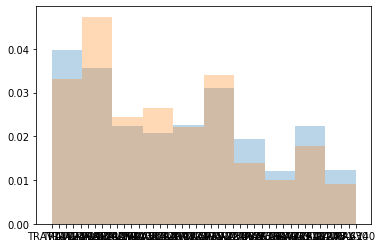

In [182]:
cmv_pos_df = pd.DataFrame(db["Receptor-PMHC-Complex"]["train"][db["Receptor-PMHC-Complex"]["train"]["frequency_A0301_KLGGALQAK_IE-1_CMV_binder"] > 0])
cmv_neg_df = pd.DataFrame(db["Receptor-PMHC-Complex"]["train"][db["Receptor-PMHC-Complex"]["train"]["frequency_A0301_KLGGALQAK_IE-1_CMV_binder"] == 0])

plt.hist(cmv_pos_df["tra_vgene"], density=True, alpha = .3)
plt.hist(cmv_neg_df["tra_vgene"], density=True, alpha = .3)

In [152]:
cmv_pos_rec = db["Receptor-PMHC-Complex"]["train"]["trb_cdr3"][db["Receptor-PMHC-Complex"]["train"]["frequency_A0301_KLGGALQAK_IE-1_CMV_binder"] > 0]
cmv_neg_rec = db["Receptor-PMHC-Complex"]["train"]["trb_cdr3"][db["Receptor-PMHC-Complex"]["train"]["frequency_A0301_KLGGALQAK_IE-1_CMV_binder"] == 0]

print(len(cmv_pos_rec))
print(len(cmv_neg_rec))

pos = [x.decode() for x in cmv_pos_rec]
neg = [x.decode() for x in cmv_neg_rec]

16586
9362


In [187]:
# OLD: python3 train_val.py --database ../dataset/database.h5 --table_train Receptor-PMHC-Complex/train --table_val Receptor-PMHC-Complex/validate --tags A0201_GILGFVFTL_Flu-MP_Influenza_binder A0301_KLGGALQAK_IE-1_CMV_binder A0301_RLRAEAQVK_EMNA-3A_EBV_binder A1101_IVTDFSVIK_EBNA-3B_EBV_binder A1101_AVFDRKSDAK_EBNA-3B_EBV_binder B0801_RAKFKQLL_BZLF1_EBV_binder --output bin/model
# NEW: python3 train_val.py --database ../dataset/database.h5 --table_train Receptor-PMHC-Complex/train --table_val Receptor-PMHC-Complex/validate --tags A0201_GILGFVFTL_Flu-MP_Influenza_binder A0301_KLGGALQAK_IE-1_CMV_binder A1101_AVFDRKSDAK_EBNA-3B_EBV_binder B0801_RAKFKQLL_BZLF1_EBV_binder --output bin/model

df_old = pd.read_csv('../data/train.data')
print(df_old["A0301_KLGGALQAK_IE-1_CMV_binder"].sum())
print(len(df_old) - df_old["A0301_KLGGALQAK_IE-1_CMV_binder"].sum())
print(df_old.columns[:4])

10177
45353
Index(['A0301_KLGGALQAK_IE-1_CMV_binder',
       'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
       'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder',
       'B0801_RAKFKQLL_BZLF1_EBV_binder'],
      dtype='object')


In [188]:
cmv_pos_rec = db["Receptor-PMHC-Complex"]["train"]["trb_cdr3"][db["Receptor-PMHC-Complex"]["train"]["frequency_A0301_KLGGALQAK_IE-1_CMV_binder"] > 0]
cmv_neg_rec = db["Receptor-PMHC-Complex"]["train"]["trb_cdr3"][db["Receptor-PMHC-Complex"]["train"]["frequency_A0301_KLGGALQAK_IE-1_CMV_binder"] == 0]

pos = [x.decode() for x in cmv_pos_rec]
neg = [x.decode() for x in cmv_neg_rec]

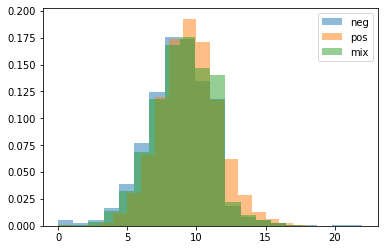

In [189]:
N = 2000
mat = np.zeros((N*2, N*2))

# don't judge
new_neg = list(np.array(neg)[np.random.choice(len(neg), N, replace=False)])
new_pos = list(np.array(pos)[np.random.choice(len(pos), N, replace=False)])

all_seq = new_neg + new_pos
mix_dist = []
pos_dist = []
neg_dist = []

for i in range(N*2-1):
    for j in range(i+1, N*2):
        dist_val = L.distance(all_seq[i], all_seq[j])
        mat[i,j] = dist_val
        
        if i < N:
            if j < N:
                neg_dist.append(dist_val)
            if j > N:
                mix_dist.append(dist_val)
        else:
            pos_dist.append(dist_val)
        
_ = plt.hist(neg_dist, alpha=.5, bins=20, label="neg", density=True)
_ = plt.hist(pos_dist, alpha=.5, bins=20, label="pos", density=True)
_ = plt.hist(mix_dist, alpha=.5, bins=20, label="mix", density=True)
plt.legend()

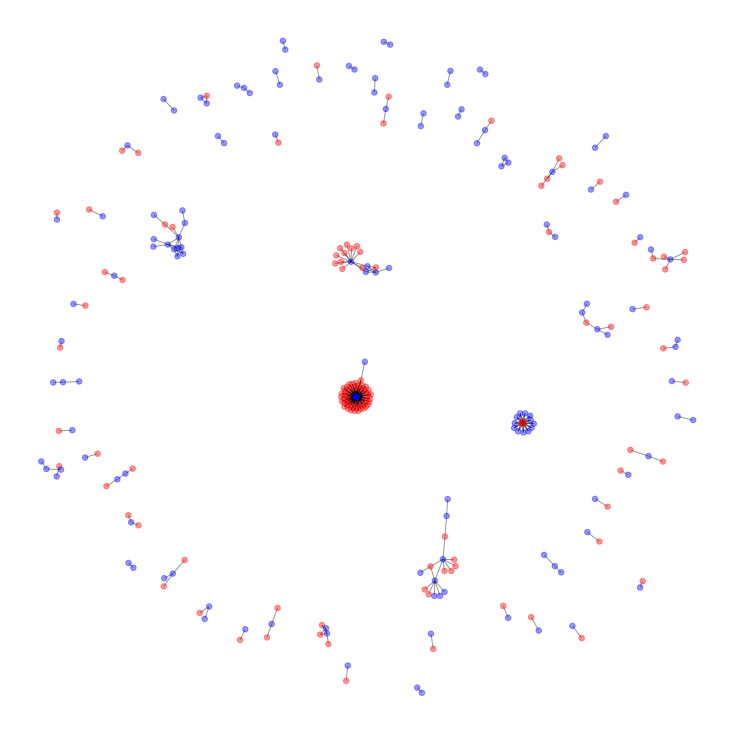

In [387]:
N = 2000
LEV_DIST = 1
LABEL = "frequency_A0301_KLGGALQAK_IE-1_CMV_binder"

# don't judge
with h5py.File("../data/database.h5") as db:
    cmv_pos_rec = db["Receptor-PMHC-Complex"]["train"]["trb_cdr3"][db["Receptor-PMHC-Complex"]["train"][LABEL] > 0]
    cmv_neg_rec = db["Receptor-PMHC-Complex"]["train"]["trb_cdr3"][db["Receptor-PMHC-Complex"]["train"][LABEL] == 0]

pos = [x.decode() for x in cmv_pos_rec]
neg = [x.decode() for x in cmv_neg_rec]

new_neg = list(np.array(neg)[np.random.choice(len(neg), N, replace=False)])
new_pos = list(np.array(pos)[np.random.choice(len(pos), N, replace=False)])

G = nx.Graph()

for i in range(len(new_pos)):
    for j in range(len(new_neg)):
        dist_val = L.distance(new_pos[i], new_neg[j])
        
        if dist_val == LEV_DIST:
            G.add_edge("P"+str(i), "N"+str(j))
            
for i in range(len(new_pos) - 1):
    for j in range(i+1, len(new_pos)):
        dist_val = L.distance(new_pos[i], new_pos[j])
        
        if dist_val == LEV_DIST:
            G.add_edge("P"+str(i), "P"+str(j))

        
plt.figure(num=None, figsize=(10, 10))
nx.draw_spring(G, node_size=30, node_color = ["red" if node.startswith("N") else "blue" for node in G.nodes], alpha=.4)

# Make RUNE-like files from DKM files

In [183]:
for label in ["validate", "train"]:
    cmv_pos_rec = db["Receptor-PMHC-Complex"][label]["trb_cdr3"][db["Receptor-PMHC-Complex"][label]["frequency_A0301_KLGGALQAK_IE-1_CMV_binder"] > 0]
    cmv_neg_rec = db["Receptor-PMHC-Complex"][label]["trb_cdr3"][db["Receptor-PMHC-Complex"][label]["frequency_A0301_KLGGALQAK_IE-1_CMV_binder"] == 0]
    pos = [x.decode() for x in cmv_pos_rec]
    neg = [x.decode() for x in cmv_neg_rec]
    
    df_new = pd.DataFrame({"TRB": list(pos) + list(neg), 
                          "A0301_KLGGALQAK_IE-1_CMV_binder": [True] * len(pos) + [False] * len(neg)}
                         )
    print(len(df_new), len(pos), len(neg))
    if label == "validate":
        label = "validation"
    df_new.to_csv("../data/" + label + ".dkm.data")

8650 5437 3213
25948 16586 9362


# Make DKM-like database from RUNE files

In [370]:
df_old = pd.read_csv('../data/train.data')
print(len(df_old))
print(df_old["A0301_KLGGALQAK_IE-1_CMV_binder"].sum())
df_old.head()

55530
10177


,A0301_KLGGALQAK_IE-1_CMV_binder,A0201_GILGFVFTL_Flu-MP_Influenza_binder,A1101_AVFDRKSDAK_EBNA-3B_EBV_binder,B0801_RAKFKQLL_BZLF1_EBV_binder,cell_clono_cdr3_aa,TRA,TRB
0,False,False,False,False,TRA:CVVSELTGGGNKLTF;TRB:CAIRLADTDTQYF,CVVSELTGGGNKLTF,CAIRLADTDTQYF
1,False,False,False,False,TRA:CALDPTLMNSGGYQKVTF;TRB:CASSLQTGGRAEAFF,CALDPTLMNSGGYQKVTF,CASSLQTGGRAEAFF
2,False,False,False,False,TRA:CAAIDGQNFVF;TRB:CASSLRQDMNTEAFF,CAAIDGQNFVF,CASSLRQDMNTEAFF
3,False,False,False,False,TRA:CAAKLSDSSYKLIF;TRB:CSAMTSGSSYEQYF,CAAKLSDSSYKLIF,CSAMTSGSSYEQYF
4,False,False,False,False,TRA:CVVSSLKTSYDKVIF;TRB:CASSPMRLRYGYTF,CVVSSLKTSYDKVIF,CASSPMRLRYGYTF


In [369]:
print(len(df_old))
print(len(df_old["TRA"].unique()))
print(len(df_old["TRB"].unique()))
df_old.loc[df_old.duplicated(["TRB"], keep=False), :].sort_values("TRB")
df_old.sort_values("A0301_KLGGALQAK_IE-1_CMV_binder", ascending=False).reset_index(drop=True)
df_old.loc[df_old.duplicated(["TRB"], keep="first"), :].reset_index(drop=True)

55530
44878
51039


,A0301_KLGGALQAK_IE-1_CMV_binder,A0201_GILGFVFTL_Flu-MP_Influenza_binder,A1101_AVFDRKSDAK_EBNA-3B_EBV_binder,B0801_RAKFKQLL_BZLF1_EBV_binder,cell_clono_cdr3_aa,TRA,TRB
0,False,False,False,False,TRA:CAVTELTGGGNKLTF;TRB:CASSPLPRLAGEETQYF,CAVTELTGGGNKLTF,CASSPLPRLAGEETQYF
1,False,False,False,False,TRA:CAAFESNDYKLSF;TRB:CASRTGLASTDTQYF,CAAFESNDYKLSF,CASRTGLASTDTQYF
2,False,False,False,False,TRA:CIVRVAGGGGNKLTF;TRB:CASRAGEHFYEQYF,CIVRVAGGGGNKLTF,CASRAGEHFYEQYF
3,False,False,False,False,TRA:CAVRLHNYGQNFVF;TRB:CASSPDYLAGGHFNTGELFF,CAVRLHNYGQNFVF,CASSPDYLAGGHFNTGELFF
4,False,False,False,False,TRA:CALDYGNNRLAF;TRB:CASRTGLASTDTQYF,CALDYGNNRLAF,CASRTGLASTDTQYF
...,...,...,...,...,...,...,...
4486,False,False,False,False,TRA:CAAGADKFYF;TRB:CASSFGGPTDTQYF,CAAGADKFYF,CASSFGGPTDTQYF
4487,False,False,False,False,TRA:CAVGDSNYQLIW;TRB:CASGDLAGGNEQFF,CAVGDSNYQLIW,CASGDLAGGNEQFF
4488,False,False,False,True,TRA:CAVGDNFNKFYF;TRB:CASSYGTGENTEAFF,CAVGDNFNKFYF,CASSYGTGENTEAFF
4489,False,True,False,False,TRA:CAGPGDGGSQGNLIF;TRB:CASSYSLQGGLDEQYF,CAGPGDGGSQGNLIF,CASSYSLQGGLDEQYF


In [326]:
for label in df_old.columns[:4]:
    print(df_old[label].sum())
    df_old[label] = df_old[label] / df_old[label].sum()
    print(df_old[label].sum())

df_old

10177
1.0000000000000002
767
1.0
652
1.0
522
1.0


,A0301_KLGGALQAK_IE-1_CMV_binder,A0201_GILGFVFTL_Flu-MP_Influenza_binder,A1101_AVFDRKSDAK_EBNA-3B_EBV_binder,B0801_RAKFKQLL_BZLF1_EBV_binder,cell_clono_cdr3_aa,TRA,TRB
0,0.0,0.0,0.000000,0.0,TRA:CVVSELTGGGNKLTF;TRB:CAIRLADTDTQYF,CVVSELTGGGNKLTF,CAIRLADTDTQYF
1,0.0,0.0,0.000000,0.0,TRA:CALDPTLMNSGGYQKVTF;TRB:CASSLQTGGRAEAFF,CALDPTLMNSGGYQKVTF,CASSLQTGGRAEAFF
2,0.0,0.0,0.000000,0.0,TRA:CAAIDGQNFVF;TRB:CASSLRQDMNTEAFF,CAAIDGQNFVF,CASSLRQDMNTEAFF
3,0.0,0.0,0.000000,0.0,TRA:CAAKLSDSSYKLIF;TRB:CSAMTSGSSYEQYF,CAAKLSDSSYKLIF,CSAMTSGSSYEQYF
4,0.0,0.0,0.000000,0.0,TRA:CVVSSLKTSYDKVIF;TRB:CASSPMRLRYGYTF,CVVSSLKTSYDKVIF,CASSPMRLRYGYTF
...,...,...,...,...,...,...,...
55525,0.0,0.0,0.000000,0.0,TRA:CALSEMYNARLMF;TRB:CASSPWDDGDSGNTIYF,CALSEMYNARLMF,CASSPWDDGDSGNTIYF
55526,0.0,0.0,0.000000,0.0,TRA:CAARASGQNFVF;TRB:CASSDPGYGYTF,CAARASGQNFVF,CASSDPGYGYTF
55527,0.0,0.0,0.000000,0.0,TRA:CAFTSDAGGTSYGKLTF;TRB:CASSLSRRGGYTF,CAFTSDAGGTSYGKLTF,CASSLSRRGGYTF
55528,0.0,0.0,0.001534,0.0,TRA:CAVRDRSNARLMF;TRB:CSDWEGGSTEAFF,CAVRDRSNARLMF,CSDWEGGSTEAFF


In [327]:
dtype_receptor = [
    ('tra_vgene', 'S16'),
    ('tra_cdr3', 'S' + str(df_old["TRA"].str.len().max())),
    ('tra_jgene', 'S16'),
    ('trb_vgene', 'S16'),
    ('trb_cdr3', 'S' + str(df_old["TRB"].str.len().max())),
    ('trb_jgene', 'S16')]
dtype_receptor += [('frequency_'+label, 'f8') for label in df_old.columns[:4]]
dtype_receptor

[('tra_vgene', 'S16'),
 ('tra_cdr3', 'S26'),
 ('tra_jgene', 'S16'),
 ('trb_vgene', 'S16'),
 ('trb_cdr3', 'S26'),
 ('trb_jgene', 'S16'),
 ('frequency_A0301_KLGGALQAK_IE-1_CMV_binder', 'f8'),
 ('frequency_A0201_GILGFVFTL_Flu-MP_Influenza_binder', 'f8'),
 ('frequency_A1101_AVFDRKSDAK_EBNA-3B_EBV_binder', 'f8'),
 ('frequency_B0801_RAKFKQLL_BZLF1_EBV_binder', 'f8')]

In [329]:
rs = np.zeros(len(df_old), dtype=dtype_receptor)
for i, record in enumerate(df_old.iterrows()):
    receptor = record[1]
    rs[i]['tra_vgene'] = np.random.choice(["TRAV1-1", "TRAV1-2"])
    rs[i]['tra_cdr3'] = receptor["TRA"]
    rs[i]['tra_jgene'] = np.random.choice(["TRAJ1-1", "TRAJ1-2"])
    
    rs[i]['trb_vgene'] = np.random.choice(["TRBV1-1", "TRBV1-2"])
    rs[i]['trb_cdr3'] = receptor["TRB"]
    rs[i]['trb_jgene'] = np.random.choice(["TRBJ1-1", "TRBJ1-2"])
    for label in df_old.columns[:4]:
        rs[i]['frequency_'+label] = receptor[label]
        
rs[:5]

array([(b'TRAV1-1', b'CVVSELTGGGNKLTF', b'TRAJ1-1', b'TRBV1-1', b'CAIRLADTDTQYF', b'TRBJ1-2', 0., 0., 0., 0.),
       (b'TRAV1-2', b'CALDPTLMNSGGYQKVTF', b'TRAJ1-1', b'TRBV1-1', b'CASSLQTGGRAEAFF', b'TRBJ1-2', 0., 0., 0., 0.),
       (b'TRAV1-2', b'CAAIDGQNFVF', b'TRAJ1-1', b'TRBV1-1', b'CASSLRQDMNTEAFF', b'TRBJ1-2', 0., 0., 0., 0.),
       (b'TRAV1-2', b'CAAKLSDSSYKLIF', b'TRAJ1-2', b'TRBV1-2', b'CSAMTSGSSYEQYF', b'TRBJ1-1', 0., 0., 0., 0.),
       (b'TRAV1-2', b'CVVSSLKTSYDKVIF', b'TRAJ1-2', b'TRBV1-1', b'CASSPMRLRYGYTF', b'TRBJ1-2', 0., 0., 0., 0.)],
      dtype=[('tra_vgene', 'S16'), ('tra_cdr3', 'S26'), ('tra_jgene', 'S16'), ('trb_vgene', 'S16'), ('trb_cdr3', 'S26'), ('trb_jgene', 'S16'), ('frequency_A0301_KLGGALQAK_IE-1_CMV_binder', '<f8'), ('frequency_A0201_GILGFVFTL_Flu-MP_Influenza_binder', '<f8'), ('frequency_A1101_AVFDRKSDAK_EBNA-3B_EBV_binder', '<f8'), ('frequency_B0801_RAKFKQLL_BZLF1_EBV_binder', '<f8')])

In [330]:
PATH = "../data/database_rune.h5"


name = "Receptor-PMHC-Complex/train"
flag = "w"
with h5py.File(PATH, flag) as db:
    rs_db = db.create_dataset(name, (rs.size,), dtype_receptor)
    rs_db[:] = rs
    

name = "Receptor-PMHC-Complex/validate"
flag = 'r+' if os.path.isfile(PATH) else 'w'
with h5py.File(PATH, flag) as db:
    rs_db = db.create_dataset(name, (1000,), dtype_receptor)
    rs_db[:] = rs[:1000]